[View in Colaboratory](https://colab.research.google.com/github/MJahangeerQureshi/Credit-card-Fraud-Detection-using-AE/blob/master/Fraud_detection.ipynb)

In [44]:
!pip install keras
!pip install kaggle
!pip install xgboost
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename))
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)
!kaggle datasets download -d mlg-ulb/creditcardfraud

FileExistsError: ignored

In [6]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 68%|█████████████████████████▉            | 45.0M/66.0M [00:00<00:00, 38.6MB/s]
100%|███████████████████████████████████████| 66.0M/66.0M [00:00<00:00, 129MB/s]


In [9]:
!unzip /content/.kaggle/datasets/mlg-ulb/creditcardfraud/creditcardfraud.zip

Archive:  /content/.kaggle/datasets/mlg-ulb/creditcardfraud/creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [10]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


## Load Data

In [15]:
df = pd.read_csv("/content/.kaggle/datasets/mlg-ulb/creditcardfraud/creditcard.csv")

## Exploring data

In [16]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [17]:
df.shape

(284807, 31)

## Checking for missing values

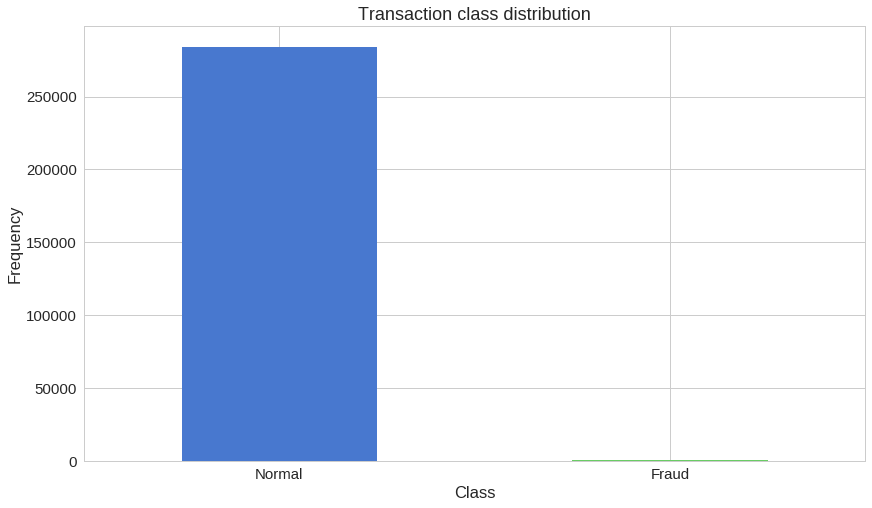

In [18]:
df.isnull().values.any()

count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [19]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [20]:
normal.shape

(284315, 31)

In [23]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [24]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

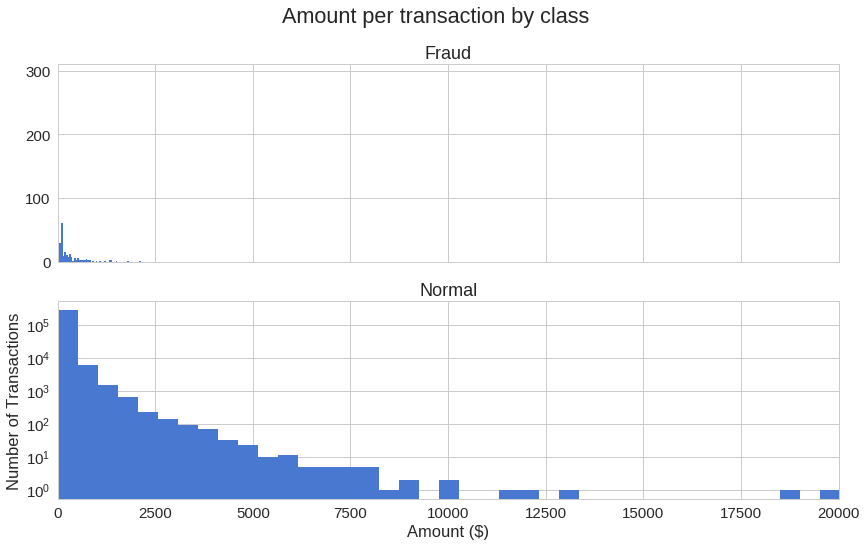

In [25]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

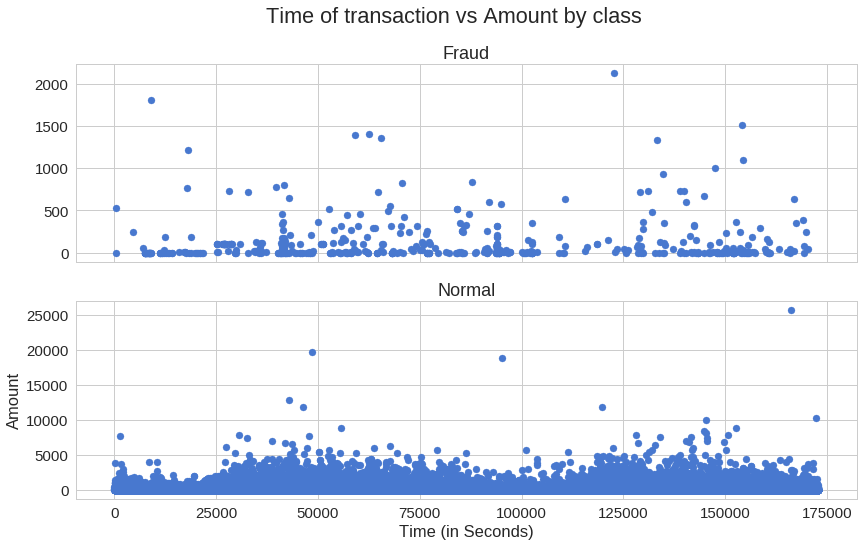

In [26]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [27]:
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [28]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(227451, 29)

In [29]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [30]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
169920/227451 [=====================>........] - ETA: 12s - loss: 0.8472 - acc: 0.5637

227451/227451 [==============================] - 51s 224us/step - loss: 0.8248 - acc: 0.5767 - val_loss: 0.8013 - val_acc: 0.6093
Epoch 2/100
 89600/227451 [==========>...................] - ETA: 28s - loss: 0.7614 - acc: 0.6153

227451/227451 [==============================] - 51s 222us/step - loss: 0.7602 - acc: 0.6197 - val_loss: 0.7856 - val_acc: 0.6242
Epoch 3/100
 59232/227451 [======>.......................] - ETA: 35s - loss: 0.7584 - acc: 0.6276

227451/227451 [==============================] - 51s 222us/step - loss: 0.7507 - acc: 0.6286 - val_loss: 0.7825 - val_acc: 0.6268
Epoch 4/100
 47872/227451 [=====>........................] - ETA: 37s - loss: 0.7565 - acc: 0.6298

227451/227451 [==============================] - 50s 221us/step - loss: 0.7462 - acc: 0.6322 - val_loss: 0.7795 - val_acc: 0.6336
Epoch 5/100
 43904/227451 [====>.........................] - ETA: 37s - loss: 0.7424 - acc: 0.6329

227451/227451 [==============================] - 50s 221us/step - loss: 0.7436 - acc: 0.6343 - val_loss: 0.7764 - val_acc: 0.6311
Epoch 6/100
 42272/227451 [====>.........................] - ETA: 39s - loss: 0.7358 - acc: 0.6341

227451/227451 [==============================] - 51s 223us/step - loss: 0.7413 - acc: 0.6355 - val_loss: 0.7731 - val_acc: 0.6368
Epoch 7/100
 41824/227451 [====>.........................] - ETA: 38s - loss: 0.7269 - acc: 0.6367

227451/227451 [==============================] - 50s 221us/step - loss: 0.7396 - acc: 0.6361 - val_loss: 0.7727 - val_acc: 0.6374
Epoch 8/100
 40896/227451 [====>.........................] - ETA: 39s - loss: 0.7385 - acc: 0.6337

227451/227451 [==============================] - 50s 222us/step - loss: 0.7383 - acc: 0.6361 - val_loss: 0.7739 - val_acc: 0.6377
Epoch 9/100
 40832/227451 [====>.........................] - ETA: 38s - loss: 0.7614 - acc: 0.6325

227451/227451 [==============================] - 50s 222us/step - loss: 0.7376 - acc: 0.6359 - val_loss: 0.7693 - val_acc: 0.6375
Epoch 10/100
 40736/227451 [====>.........................] - ETA: 38s - loss: 0.7424 - acc: 0.6364

227451/227451 [==============================] - 51s 223us/step - loss: 0.7372 - acc: 0.6362 - val_loss: 0.7716 - val_acc: 0.6386
Epoch 11/100
 40480/227451 [====>.........................] - ETA: 38s - loss: 0.7286 - acc: 0.6368

227451/227451 [==============================] - 50s 222us/step - loss: 0.7361 - acc: 0.6360 - val_loss: 0.7688 - val_acc: 0.6389
Epoch 12/100
 40480/227451 [====>.........................] - ETA: 38s - loss: 0.7165 - acc: 0.6337

227451/227451 [==============================] - 50s 222us/step - loss: 0.7357 - acc: 0.6358 - val_loss: 0.7689 - val_acc: 0.6368
Epoch 13/100
 40384/227451 [====>.........................] - ETA: 39s - loss: 0.7312 - acc: 0.6326

227451/227451 [==============================] - 50s 222us/step - loss: 0.7349 - acc: 0.6362 - val_loss: 0.7696 - val_acc: 0.6355
Epoch 14/100
 41216/227451 [====>.........................] - ETA: 37s - loss: 0.7319 - acc: 0.6369

227451/227451 [==============================] - 50s 220us/step - loss: 0.7344 - acc: 0.6366 - val_loss: 0.7762 - val_acc: 0.6215
Epoch 15/100
 41216/227451 [====>.........................] - ETA: 38s - loss: 0.7258 - acc: 0.6402

227451/227451 [==============================] - 50s 222us/step - loss: 0.7339 - acc: 0.6373 - val_loss: 0.7677 - val_acc: 0.6367
Epoch 16/100
 40512/227451 [====>.........................] - ETA: 39s - loss: 0.6990 - acc: 0.6365

227451/227451 [==============================] - 50s 221us/step - loss: 0.7337 - acc: 0.6377 - val_loss: 0.7678 - val_acc: 0.6346
Epoch 17/100
 41376/227451 [====>.........................] - ETA: 37s - loss: 0.7470 - acc: 0.6348

227451/227451 [==============================] - 50s 220us/step - loss: 0.7336 - acc: 0.6375 - val_loss: 0.7674 - val_acc: 0.6371
Epoch 18/100
 41600/227451 [====>.........................] - ETA: 38s - loss: 0.7484 - acc: 0.6384

227451/227451 [==============================] - 50s 221us/step - loss: 0.7333 - acc: 0.6375 - val_loss: 0.7674 - val_acc: 0.6313
Epoch 19/100
 41536/227451 [====>.........................] - ETA: 37s - loss: 0.7465 - acc: 0.6331

227451/227451 [==============================] - 50s 218us/step - loss: 0.7331 - acc: 0.6369 - val_loss: 0.7712 - val_acc: 0.6354
Epoch 20/100
 42016/227451 [====>.........................] - ETA: 38s - loss: 0.7310 - acc: 0.6345

227451/227451 [==============================] - 50s 221us/step - loss: 0.7326 - acc: 0.6379 - val_loss: 0.7666 - val_acc: 0.6424
Epoch 21/100
 41344/227451 [====>.........................] - ETA: 38s - loss: 0.7270 - acc: 0.6397

227451/227451 [==============================] - 50s 219us/step - loss: 0.7327 - acc: 0.6366 - val_loss: 0.7718 - val_acc: 0.6323
Epoch 22/100
 42432/227451 [====>.........................] - ETA: 37s - loss: 0.7824 - acc: 0.6353

227451/227451 [==============================] - 50s 220us/step - loss: 0.7323 - acc: 0.6386 - val_loss: 0.7667 - val_acc: 0.6383
Epoch 23/100
 41888/227451 [====>.........................] - ETA: 38s - loss: 0.7079 - acc: 0.6354

227451/227451 [==============================] - 50s 220us/step - loss: 0.7326 - acc: 0.6379 - val_loss: 0.7659 - val_acc: 0.6374
Epoch 24/100
 42208/227451 [====>.........................] - ETA: 37s - loss: 0.7161 - acc: 0.6354

227451/227451 [==============================] - 50s 219us/step - loss: 0.7321 - acc: 0.6378 - val_loss: 0.7682 - val_acc: 0.6351
Epoch 25/100
 42656/227451 [====>.........................] - ETA: 37s - loss: 0.7175 - acc: 0.6381

227451/227451 [==============================] - 50s 220us/step - loss: 0.7322 - acc: 0.6377 - val_loss: 0.7691 - val_acc: 0.6372
Epoch 26/100
 42368/227451 [====>.........................] - ETA: 37s - loss: 0.7227 - acc: 0.6359

227451/227451 [==============================] - 50s 219us/step - loss: 0.7318 - acc: 0.6381 - val_loss: 0.7658 - val_acc: 0.6384
Epoch 27/100
 42368/227451 [====>.........................] - ETA: 38s - loss: 0.7294 - acc: 0.6407

227451/227451 [==============================] - 50s 219us/step - loss: 0.7320 - acc: 0.6381 - val_loss: 0.7695 - val_acc: 0.6308
Epoch 28/100
 42016/227451 [====>.........................] - ETA: 38s - loss: 0.6919 - acc: 0.6414

227451/227451 [==============================] - 50s 220us/step - loss: 0.7323 - acc: 0.6388 - val_loss: 0.7657 - val_acc: 0.6373
Epoch 29/100
 41920/227451 [====>.........................] - ETA: 38s - loss: 0.7380 - acc: 0.6363

227451/227451 [==============================] - 50s 220us/step - loss: 0.7316 - acc: 0.6379 - val_loss: 0.7671 - val_acc: 0.6258
Epoch 30/100
 41824/227451 [====>.........................] - ETA: 38s - loss: 0.7560 - acc: 0.6386

227451/227451 [==============================] - 50s 219us/step - loss: 0.7319 - acc: 0.6382 - val_loss: 0.7661 - val_acc: 0.6366
Epoch 31/100
 42880/227451 [====>.........................] - ETA: 37s - loss: 0.7580 - acc: 0.6386

227451/227451 [==============================] - 49s 217us/step - loss: 0.7318 - acc: 0.6384 - val_loss: 0.7657 - val_acc: 0.6395
Epoch 32/100
 42944/227451 [====>.........................] - ETA: 37s - loss: 0.7252 - acc: 0.6393

227451/227451 [==============================] - 50s 220us/step - loss: 0.7317 - acc: 0.6377 - val_loss: 0.7655 - val_acc: 0.6388
Epoch 33/100
 42144/227451 [====>.........................] - ETA: 38s - loss: 0.7079 - acc: 0.6407

227451/227451 [==============================] - 51s 223us/step - loss: 0.7314 - acc: 0.6381 - val_loss: 0.7675 - val_acc: 0.6368
Epoch 34/100
 40704/227451 [====>.........................] - ETA: 39s - loss: 0.7320 - acc: 0.6402

227451/227451 [==============================] - 51s 224us/step - loss: 0.7312 - acc: 0.6384 - val_loss: 0.7652 - val_acc: 0.6376
Epoch 35/100
 40256/227451 [====>.........................] - ETA: 39s - loss: 0.6944 - acc: 0.6378

227451/227451 [==============================] - 51s 222us/step - loss: 0.7317 - acc: 0.6385 - val_loss: 0.7655 - val_acc: 0.6337
Epoch 36/100
 40544/227451 [====>.........................] - ETA: 38s - loss: 0.7336 - acc: 0.6351

227451/227451 [==============================] - 50s 221us/step - loss: 0.7311 - acc: 0.6382 - val_loss: 0.7644 - val_acc: 0.6377
Epoch 37/100
 41024/227451 [====>.........................] - ETA: 38s - loss: 0.7450 - acc: 0.6314

227451/227451 [==============================] - 50s 222us/step - loss: 0.7314 - acc: 0.6378 - val_loss: 0.7653 - val_acc: 0.6348
Epoch 38/100
 40992/227451 [====>.........................] - ETA: 38s - loss: 0.7503 - acc: 0.6399

227451/227451 [==============================] - 50s 220us/step - loss: 0.7310 - acc: 0.6384 - val_loss: 0.7647 - val_acc: 0.6389
Epoch 39/100
 41472/227451 [====>.........................] - ETA: 38s - loss: 0.7120 - acc: 0.6405

227451/227451 [==============================] - 50s 221us/step - loss: 0.7313 - acc: 0.6383 - val_loss: 0.7649 - val_acc: 0.6396
Epoch 40/100
 41280/227451 [====>.........................] - ETA: 38s - loss: 0.7555 - acc: 0.6337

227451/227451 [==============================] - 50s 220us/step - loss: 0.7309 - acc: 0.6381 - val_loss: 0.7700 - val_acc: 0.6337
Epoch 41/100
 41568/227451 [====>.........................] - ETA: 38s - loss: 0.7577 - acc: 0.6359

227451/227451 [==============================] - 50s 220us/step - loss: 0.7310 - acc: 0.6382 - val_loss: 0.7667 - val_acc: 0.6374
Epoch 42/100
 42144/227451 [====>.........................] - ETA: 37s - loss: 0.7064 - acc: 0.6348

227451/227451 [==============================] - 50s 219us/step - loss: 0.7311 - acc: 0.6381 - val_loss: 0.7651 - val_acc: 0.6368
Epoch 43/100
 42400/227451 [====>.........................] - ETA: 37s - loss: 0.7543 - acc: 0.6374

227451/227451 [==============================] - 50s 220us/step - loss: 0.7306 - acc: 0.6380 - val_loss: 0.7688 - val_acc: 0.6357
Epoch 44/100
 41504/227451 [====>.........................] - ETA: 38s - loss: 0.7361 - acc: 0.6387

227451/227451 [==============================] - 50s 221us/step - loss: 0.7315 - acc: 0.6392 - val_loss: 0.7660 - val_acc: 0.6376
Epoch 45/100
 41344/227451 [====>.........................] - ETA: 38s - loss: 0.7254 - acc: 0.6383

227451/227451 [==============================] - 50s 221us/step - loss: 0.7309 - acc: 0.6391 - val_loss: 0.7648 - val_acc: 0.6335
Epoch 46/100
 41120/227451 [====>.........................] - ETA: 38s - loss: 0.7274 - acc: 0.6357

227451/227451 [==============================] - 51s 223us/step - loss: 0.7311 - acc: 0.6379 - val_loss: 0.7645 - val_acc: 0.6397
Epoch 47/100
 41056/227451 [====>.........................] - ETA: 38s - loss: 0.7230 - acc: 0.6428

227451/227451 [==============================] - 50s 221us/step - loss: 0.7308 - acc: 0.6392 - val_loss: 0.7642 - val_acc: 0.6406
Epoch 48/100
 40992/227451 [====>.........................] - ETA: 38s - loss: 0.7214 - acc: 0.6392

227451/227451 [==============================] - 50s 220us/step - loss: 0.7309 - acc: 0.6387 - val_loss: 0.7699 - val_acc: 0.6330
Epoch 49/100
 41472/227451 [====>.........................] - ETA: 38s - loss: 0.7392 - acc: 0.6398

227451/227451 [==============================] - 50s 220us/step - loss: 0.7307 - acc: 0.6395 - val_loss: 0.7658 - val_acc: 0.6367
Epoch 50/100
 41696/227451 [====>.........................] - ETA: 38s - loss: 0.7262 - acc: 0.6359

227451/227451 [==============================] - 50s 221us/step - loss: 0.7306 - acc: 0.6396 - val_loss: 0.7652 - val_acc: 0.6368
Epoch 51/100
 41248/227451 [====>.........................] - ETA: 38s - loss: 0.7097 - acc: 0.6399

227451/227451 [==============================] - 51s 222us/step - loss: 0.7307 - acc: 0.6390 - val_loss: 0.7642 - val_acc: 0.6414
Epoch 52/100
 41024/227451 [====>.........................] - ETA: 38s - loss: 0.7235 - acc: 0.6380

227451/227451 [==============================] - 50s 220us/step - loss: 0.7306 - acc: 0.6391 - val_loss: 0.7658 - val_acc: 0.6357
Epoch 53/100
 41408/227451 [====>.........................] - ETA: 38s - loss: 0.7334 - acc: 0.6446

227451/227451 [==============================] - 50s 220us/step - loss: 0.7307 - acc: 0.6393 - val_loss: 0.7677 - val_acc: 0.6370
Epoch 54/100
 41344/227451 [====>.........................] - ETA: 38s - loss: 0.7328 - acc: 0.6389

227451/227451 [==============================] - 50s 221us/step - loss: 0.7304 - acc: 0.6392 - val_loss: 0.7643 - val_acc: 0.6414
Epoch 55/100
 41440/227451 [====>.........................] - ETA: 38s - loss: 0.7442 - acc: 0.6410

227451/227451 [==============================] - 50s 219us/step - loss: 0.7303 - acc: 0.6390 - val_loss: 0.7645 - val_acc: 0.6364
Epoch 56/100
 41824/227451 [====>.........................] - ETA: 38s - loss: 0.7588 - acc: 0.6399

227451/227451 [==============================] - 50s 221us/step - loss: 0.7304 - acc: 0.6388 - val_loss: 0.7732 - val_acc: 0.6289
Epoch 57/100
 42368/227451 [====>.........................] - ETA: 37s - loss: 0.7168 - acc: 0.6422

227451/227451 [==============================] - 50s 218us/step - loss: 0.7309 - acc: 0.6398 - val_loss: 0.7650 - val_acc: 0.6406
Epoch 58/100
 42784/227451 [====>.........................] - ETA: 38s - loss: 0.7325 - acc: 0.6381

227451/227451 [==============================] - 50s 221us/step - loss: 0.7304 - acc: 0.6398 - val_loss: 0.7664 - val_acc: 0.6445
Epoch 59/100
 41984/227451 [====>.........................] - ETA: 38s - loss: 0.7546 - acc: 0.6415

227451/227451 [==============================] - 51s 222us/step - loss: 0.7307 - acc: 0.6398 - val_loss: 0.7634 - val_acc: 0.6446
Epoch 60/100
 41344/227451 [====>.........................] - ETA: 38s - loss: 0.7283 - acc: 0.6417

227451/227451 [==============================] - 50s 222us/step - loss: 0.7303 - acc: 0.6398 - val_loss: 0.7643 - val_acc: 0.6414
Epoch 61/100
 40992/227451 [====>.........................] - ETA: 38s - loss: 0.7052 - acc: 0.6443

227451/227451 [==============================] - 50s 221us/step - loss: 0.7302 - acc: 0.6403 - val_loss: 0.7681 - val_acc: 0.6385
Epoch 62/100
 41280/227451 [====>.........................] - ETA: 38s - loss: 0.7133 - acc: 0.6402

227451/227451 [==============================] - 50s 221us/step - loss: 0.7305 - acc: 0.6393 - val_loss: 0.7637 - val_acc: 0.6405
Epoch 63/100
 41696/227451 [====>.........................] - ETA: 38s - loss: 0.7240 - acc: 0.6359

227451/227451 [==============================] - 50s 220us/step - loss: 0.7302 - acc: 0.6398 - val_loss: 0.7650 - val_acc: 0.6435
Epoch 64/100
 41568/227451 [====>.........................] - ETA: 38s - loss: 0.7417 - acc: 0.6372

227451/227451 [==============================] - 50s 219us/step - loss: 0.7305 - acc: 0.6403 - val_loss: 0.7655 - val_acc: 0.6378
Epoch 65/100
 42240/227451 [====>.........................] - ETA: 38s - loss: 0.7481 - acc: 0.6419

227451/227451 [==============================] - 50s 220us/step - loss: 0.7301 - acc: 0.6398 - val_loss: 0.7637 - val_acc: 0.6509
Epoch 66/100
 41472/227451 [====>.........................] - ETA: 38s - loss: 0.7541 - acc: 0.6403

227451/227451 [==============================] - 50s 221us/step - loss: 0.7305 - acc: 0.6401 - val_loss: 0.7656 - val_acc: 0.6375
Epoch 67/100
 41568/227451 [====>.........................] - ETA: 38s - loss: 0.7571 - acc: 0.6436

227451/227451 [==============================] - 50s 219us/step - loss: 0.7299 - acc: 0.6405 - val_loss: 0.7640 - val_acc: 0.6438
Epoch 68/100
 41760/227451 [====>.........................] - ETA: 38s - loss: 0.7412 - acc: 0.6413

227451/227451 [==============================] - 50s 220us/step - loss: 0.7300 - acc: 0.6401 - val_loss: 0.7657 - val_acc: 0.6405
Epoch 69/100
 41920/227451 [====>.........................] - ETA: 38s - loss: 0.7623 - acc: 0.6399

227451/227451 [==============================] - 50s 219us/step - loss: 0.7301 - acc: 0.6400 - val_loss: 0.7658 - val_acc: 0.6408
Epoch 70/100
 42080/227451 [====>.........................] - ETA: 38s - loss: 0.7174 - acc: 0.6394

227451/227451 [==============================] - 50s 219us/step - loss: 0.7304 - acc: 0.6398 - val_loss: 0.7679 - val_acc: 0.6398
Epoch 71/100
 42336/227451 [====>.........................] - ETA: 37s - loss: 0.7164 - acc: 0.6410

227451/227451 [==============================] - 50s 218us/step - loss: 0.7299 - acc: 0.6406 - val_loss: 0.7647 - val_acc: 0.6395
Epoch 72/100
 42880/227451 [====>.........................] - ETA: 37s - loss: 0.7199 - acc: 0.6441

227451/227451 [==============================] - 50s 218us/step - loss: 0.7304 - acc: 0.6409 - val_loss: 0.7658 - val_acc: 0.6365
Epoch 73/100
 42720/227451 [====>.........................] - ETA: 38s - loss: 0.7706 - acc: 0.6385

227451/227451 [==============================] - 50s 221us/step - loss: 0.7299 - acc: 0.6407 - val_loss: 0.7645 - val_acc: 0.6406
Epoch 74/100
 42176/227451 [====>.........................] - ETA: 37s - loss: 0.7180 - acc: 0.6392

227451/227451 [==============================] - 50s 220us/step - loss: 0.7306 - acc: 0.6401 - val_loss: 0.7658 - val_acc: 0.6411
Epoch 75/100
 42112/227451 [====>.........................] - ETA: 38s - loss: 0.7196 - acc: 0.6399

227451/227451 [==============================] - 50s 220us/step - loss: 0.7301 - acc: 0.6408 - val_loss: 0.7655 - val_acc: 0.6433
Epoch 76/100
 41024/227451 [====>.........................] - ETA: 39s - loss: 0.7135 - acc: 0.6402

227451/227451 [==============================] - 50s 221us/step - loss: 0.7298 - acc: 0.6410 - val_loss: 0.7642 - val_acc: 0.6399
Epoch 77/100
 41024/227451 [====>.........................] - ETA: 38s - loss: 0.7231 - acc: 0.6396

227451/227451 [==============================] - 50s 220us/step - loss: 0.7301 - acc: 0.6410 - val_loss: 0.7641 - val_acc: 0.6422
Epoch 78/100
 41472/227451 [====>.........................] - ETA: 38s - loss: 0.7205 - acc: 0.6402

227451/227451 [==============================] - 50s 220us/step - loss: 0.7302 - acc: 0.6410 - val_loss: 0.7649 - val_acc: 0.6394
Epoch 79/100
 41664/227451 [====>.........................] - ETA: 38s - loss: 0.7363 - acc: 0.6392

227451/227451 [==============================] - 50s 221us/step - loss: 0.7300 - acc: 0.6417 - val_loss: 0.7670 - val_acc: 0.6380
Epoch 80/100
 41344/227451 [====>.........................] - ETA: 38s - loss: 0.7168 - acc: 0.6413

227451/227451 [==============================] - 50s 221us/step - loss: 0.7301 - acc: 0.6418 - val_loss: 0.7643 - val_acc: 0.6401
Epoch 81/100
 41216/227451 [====>.........................] - ETA: 38s - loss: 0.7500 - acc: 0.6425

227451/227451 [==============================] - 50s 220us/step - loss: 0.7298 - acc: 0.6423 - val_loss: 0.7635 - val_acc: 0.6427
Epoch 82/100
 41504/227451 [====>.........................] - ETA: 38s - loss: 0.7333 - acc: 0.6451

227451/227451 [==============================] - 50s 221us/step - loss: 0.7298 - acc: 0.6427 - val_loss: 0.7652 - val_acc: 0.6451
Epoch 83/100
 40896/227451 [====>.........................] - ETA: 38s - loss: 0.7406 - acc: 0.6439

227451/227451 [==============================] - 51s 223us/step - loss: 0.7296 - acc: 0.6434 - val_loss: 0.7670 - val_acc: 0.6413
Epoch 84/100
 40896/227451 [====>.........................] - ETA: 38s - loss: 0.7145 - acc: 0.6428

227451/227451 [==============================] - 50s 220us/step - loss: 0.7300 - acc: 0.6433 - val_loss: 0.7659 - val_acc: 0.6467
Epoch 85/100
 41664/227451 [====>.........................] - ETA: 37s - loss: 0.7260 - acc: 0.6425

227451/227451 [==============================] - 50s 220us/step - loss: 0.7298 - acc: 0.6455 - val_loss: 0.7684 - val_acc: 0.6398
Epoch 86/100
 42368/227451 [====>.........................] - ETA: 37s - loss: 0.7148 - acc: 0.6455

227451/227451 [==============================] - 50s 221us/step - loss: 0.7297 - acc: 0.6473 - val_loss: 0.7641 - val_acc: 0.6478
Epoch 87/100
 41760/227451 [====>.........................] - ETA: 38s - loss: 0.7315 - acc: 0.6503

227451/227451 [==============================] - 50s 221us/step - loss: 0.7297 - acc: 0.6476 - val_loss: 0.7674 - val_acc: 0.6458
Epoch 88/100
 41344/227451 [====>.........................] - ETA: 38s - loss: 0.7288 - acc: 0.6479

227451/227451 [==============================] - 50s 220us/step - loss: 0.7297 - acc: 0.6488 - val_loss: 0.7669 - val_acc: 0.6512
Epoch 89/100
 41824/227451 [====>.........................] - ETA: 38s - loss: 0.6954 - acc: 0.6497

227451/227451 [==============================] - 50s 221us/step - loss: 0.7304 - acc: 0.6505 - val_loss: 0.7643 - val_acc: 0.6545
Epoch 90/100
 41344/227451 [====>.........................] - ETA: 38s - loss: 0.7072 - acc: 0.6470

227451/227451 [==============================] - 51s 223us/step - loss: 0.7298 - acc: 0.6502 - val_loss: 0.7673 - val_acc: 0.6502
Epoch 91/100
 40384/227451 [====>.........................] - ETA: 39s - loss: 0.7232 - acc: 0.6531

227451/227451 [==============================] - 50s 222us/step - loss: 0.7292 - acc: 0.6514 - val_loss: 0.7633 - val_acc: 0.6476
Epoch 92/100
 40896/227451 [====>.........................] - ETA: 38s - loss: 0.7187 - acc: 0.6473

227451/227451 [==============================] - 50s 222us/step - loss: 0.7296 - acc: 0.6513 - val_loss: 0.7632 - val_acc: 0.6499
Epoch 93/100
 40864/227451 [====>.........................] - ETA: 38s - loss: 0.7411 - acc: 0.6518

227451/227451 [==============================] - 50s 222us/step - loss: 0.7298 - acc: 0.6510 - val_loss: 0.7646 - val_acc: 0.6526
Epoch 94/100
 41088/227451 [====>.........................] - ETA: 38s - loss: 0.7369 - acc: 0.6518

227451/227451 [==============================] - 50s 221us/step - loss: 0.7295 - acc: 0.6526 - val_loss: 0.7639 - val_acc: 0.6500
Epoch 95/100
 40896/227451 [====>.........................] - ETA: 38s - loss: 0.7021 - acc: 0.6526

227451/227451 [==============================] - 50s 221us/step - loss: 0.7297 - acc: 0.6534 - val_loss: 0.7651 - val_acc: 0.6529
Epoch 96/100
 41056/227451 [====>.........................] - ETA: 38s - loss: 0.7245 - acc: 0.6551

227451/227451 [==============================] - 51s 222us/step - loss: 0.7294 - acc: 0.6529 - val_loss: 0.7639 - val_acc: 0.6560
Epoch 97/100
 40800/227451 [====>.........................] - ETA: 38s - loss: 0.7140 - acc: 0.6537

227451/227451 [==============================] - 50s 220us/step - loss: 0.7294 - acc: 0.6540 - val_loss: 0.7631 - val_acc: 0.6497
Epoch 98/100
 41248/227451 [====>.........................] - ETA: 38s - loss: 0.6964 - acc: 0.6544

227451/227451 [==============================] - 50s 221us/step - loss: 0.7293 - acc: 0.6534 - val_loss: 0.7626 - val_acc: 0.6527
Epoch 99/100
 40960/227451 [====>.........................] - ETA: 38s - loss: 0.7231 - acc: 0.6536

227451/227451 [==============================] - 50s 221us/step - loss: 0.7296 - acc: 0.6541 - val_loss: 0.7663 - val_acc: 0.6490
Epoch 100/100
 40896/227451 [====>.........................] - ETA: 38s - loss: 0.7179 - acc: 0.6529

227451/227451 [==============================] - 50s 221us/step - loss: 0.7293 - acc: 0.6547 - val_loss: 0.7636 - val_acc: 0.6507


In [31]:
autoencoder = load_model('model.h5')

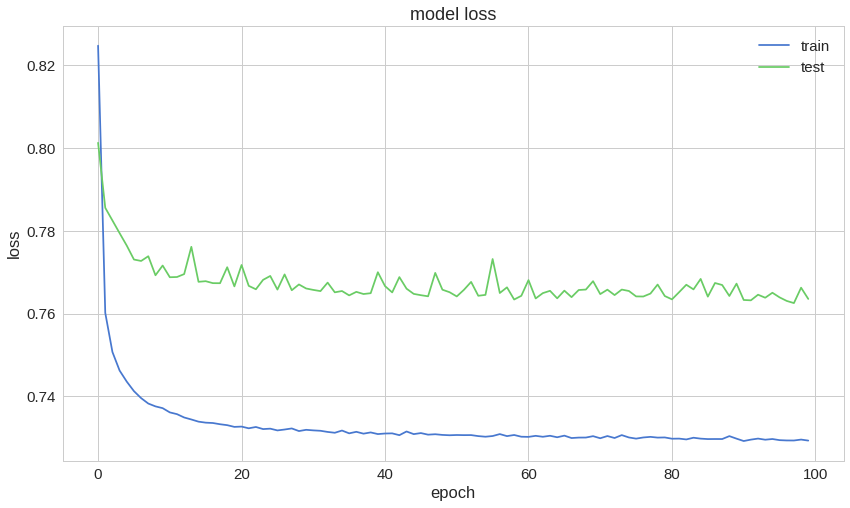

In [32]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [33]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.755188,0.001720
std,3.429369,0.041443
min,0.049423,0.000000
25%,0.249260,0.000000
50%,0.406879,0.000000
75%,0.636577,0.000000
max,263.902507,1.000000


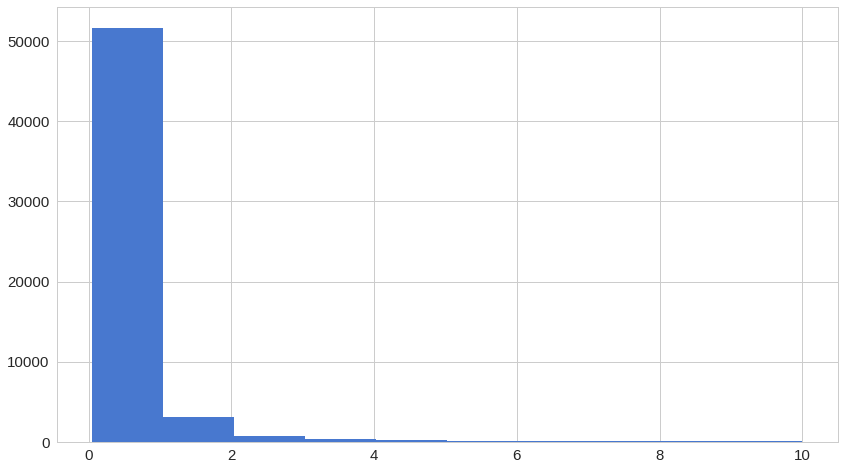

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

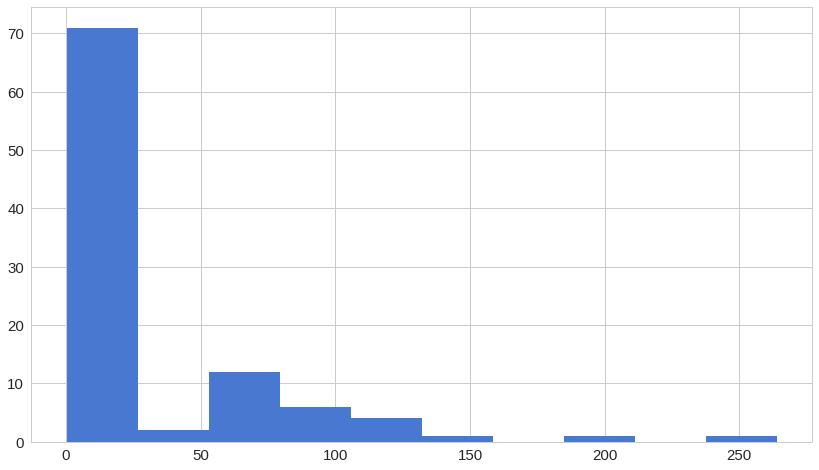

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [36]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

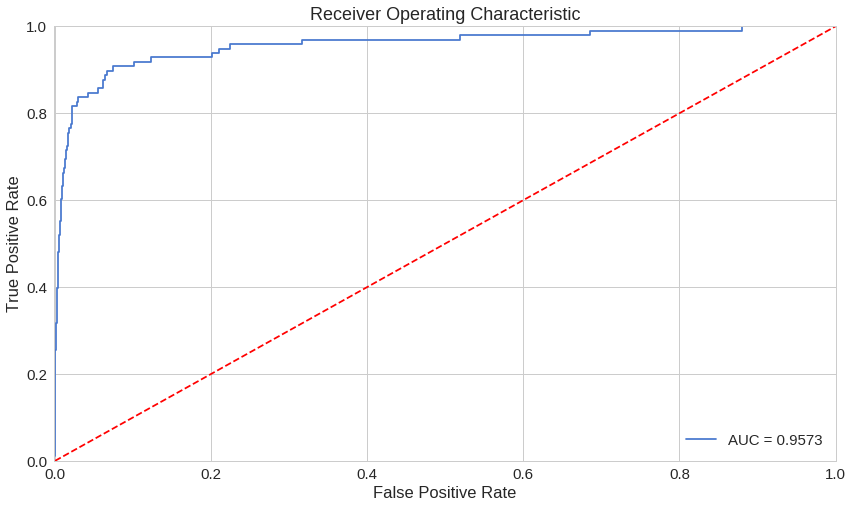

In [37]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

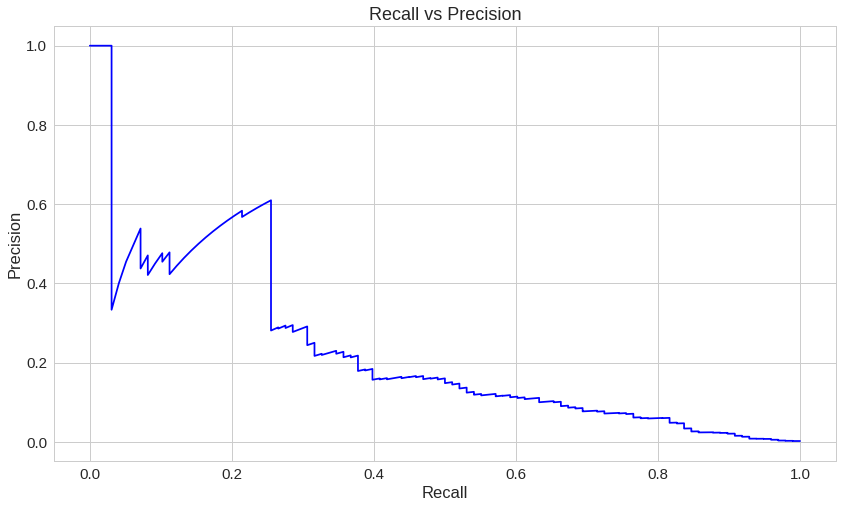

In [38]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

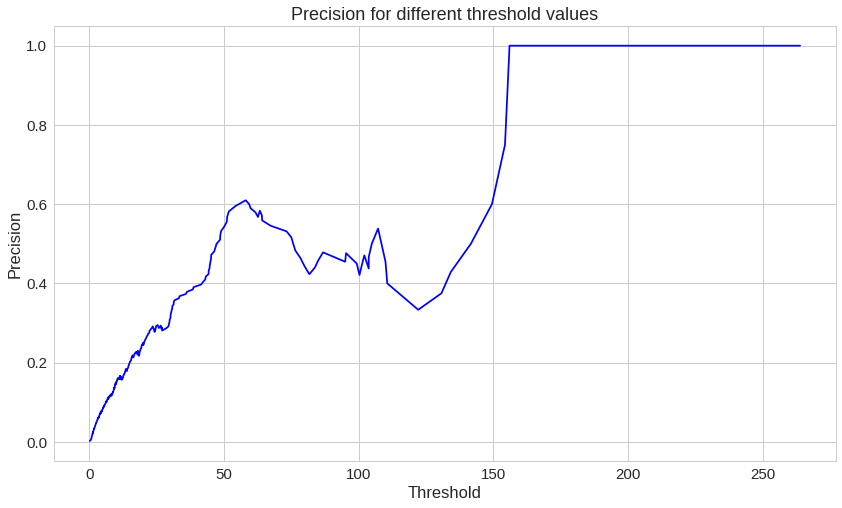

In [39]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

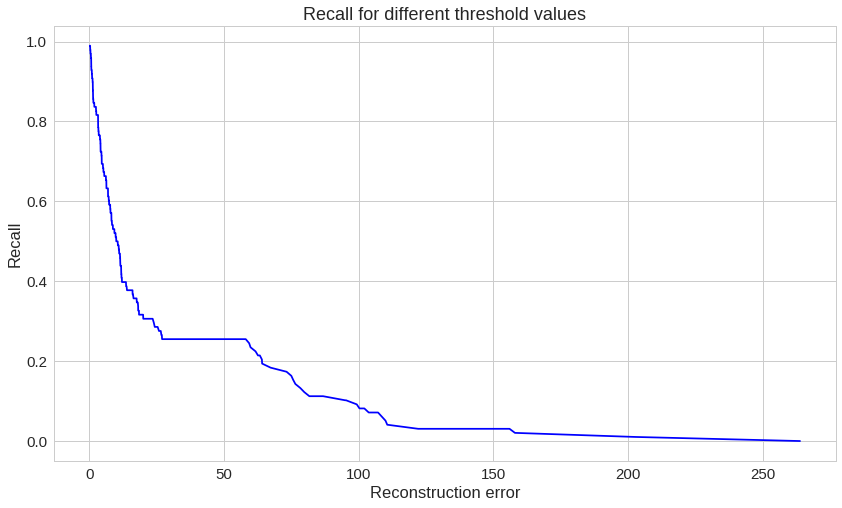

In [40]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

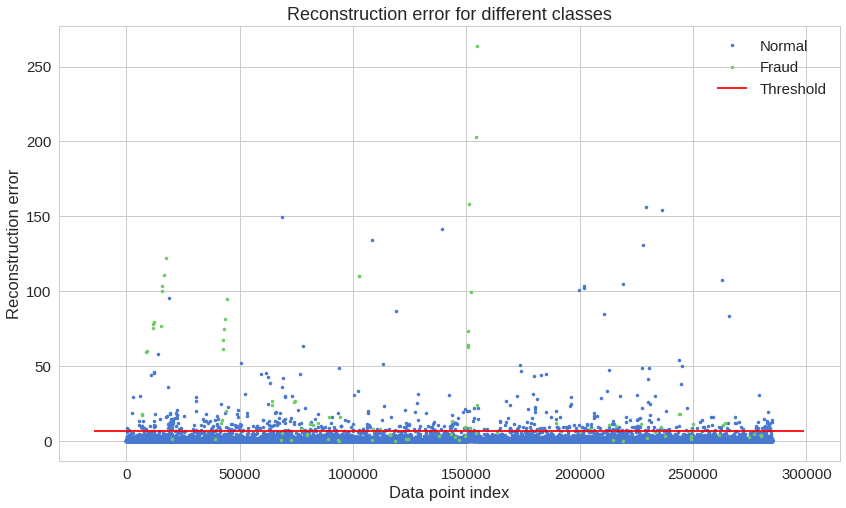

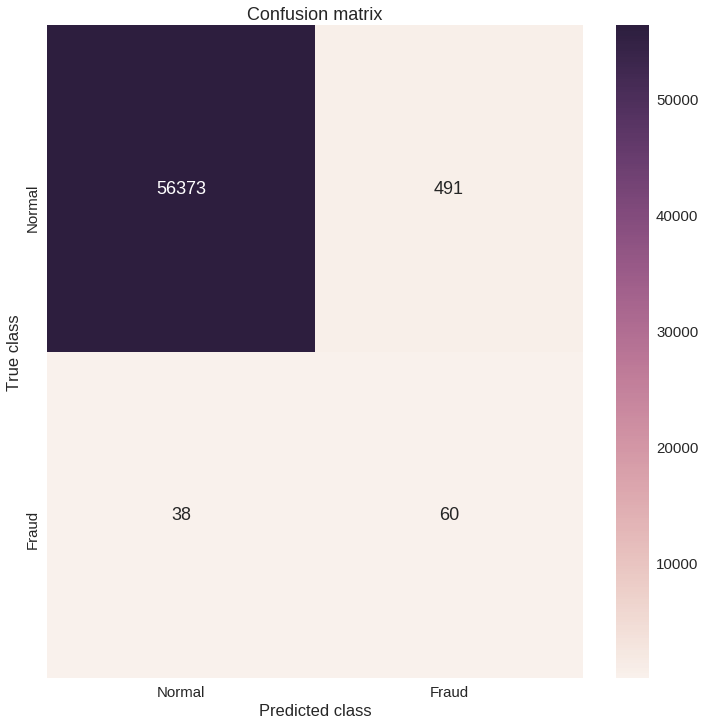

In [59]:
threshold = 7

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()